In [1]:
import os
import re
import sys
import glob
from collections import defaultdict
from functools import reduce, partial
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import spatial
import ete3
from ete3 import PhyloTree
from Bio import SeqIO
from Bio import pairwise2, SeqRecord, Seq
from Bio.Data import CodonTable

import pymutspec
from pymutspec.annotation import mutations_summary, calculate_mutspec, lbl_id2lbl, lbl2lbl_id, CodonAnnotation
from pymutspec.constants import possible_sbs192, possible_sbs12
from pymutspec.io import GenesStates

### Mammals

In [4]:
ref = next(SeqIO.parse("../data/mammals/raw/outgrp.gb", format="gb"))
ref.description

'Cociella crocodila voucher HABs-2016-007 mitochondrion, complete genome'

In [6]:
for f in ref.features:
    if f.type == "CDS":
        if f.qualifiers["gene"] == ['CYTB']:
            cytb = str(f.extract(ref.seq))
        if f.qualifiers["gene"] == ['ND1']:
            nd1 = str(f.extract(ref.seq))

In [7]:
print(cytb)
print(nd1)

ATGGCCAACTTACGAAAAACCCACCCCTTACTCAAAATTGCTAACAATGCTTTAGTAGACCTCCCCGCCCCCTCCAACATCTCCGCATGATGAAACTTTGGGTCCCTTTTAGGACTATGCTTAATTATCCAAATCCTCTCAGGCTTATTTCTAGCTATACATTACACATCAGATGTCGCTACAGCCTTCTCCTCCGTTGCCCACATCTGCCGAGACGTAAATTACGGCTGGCTAATTCGCAATCTCCACGCAAACGGAGCATCATTCTTTTTTATCTGCATTTATATACACATCGGACGCGGCCTCTACTACGGATCATACCTTTTTAAAGAGACATGAAACATTGGCGTCGTGCTCTTGCTCCTCGTAATAGTCACCGCTTTCGTGGGCTACGTCCTCCCCTGAGGACAAATATCATTCTGAGGCGCCACGGTTATTACCAACCTTCTGTCCGCCGTCCCTTATATTGGTAACACCCTCGTTCAATGAATCTGAGGAGGCTTCTCAGTAGATAATGCTACATTAAACCGTTTCTTCGCGTTCCATTTCCTTTTCCCGTTCATCATCGCAGCCGCCACTATAATCCACCTTCTATTCCTTCACCAAACTGGTTCTAACAACCCGCTTGGGCTATGGCTCAACACAGACAAAATTTCCTTCCACCCCTACTTCTCATATAAAGACCTCTTAGGGTTCGCAGGCCTTCTACTGACCTTAACAGCTTTAGCACTTTTTTCTCCCAACCTCTTAGGAGATCCTGATAACTTCACCCCGGCCAACCCCCTCGTAACCCCTCCCCATATTAAACCAGAATGATACTTCTTATTTGCATACGCTATTCTCCGCTCAATCCCTAATAAACTAGGAGGCGTACTAGCCCTCCTAGCCTCAATCTTAATTCTCATACTAATCCCGATTCTTCACACATCAAAACAACGAAGTTTAACATTCCGCCCTGTCTCTCAACTCCTGTTCTGGGCCCTTATTGCAGACGTCGCAA

## Data

In [12]:
ref = pymutspec.io.read_genbank_ref("../data/NC_012920.1.gb")

In [3]:
def get_gene(gname: str):
    """
    ['ND1', 'ND2', 'COX1', 'COX2', 'ATP8', 'ATP6', 'COX3', 'ND3',
       'ND4L', 'ND4', 'ND5', 'ND6', 'CYTB']
    """
    seq = "".join(ref[ref.GeneName == gname].Nuc.values)
    return seq 

In [30]:
ct = CodonTable.unambiguous_dna_by_id[2]

for g in ['ND1', 'CYTB']:
    s = Seq.Seq(get_gene(g))
    print(g)
    print(str(s.translate(2)))
    print()

ND1
MPMANLLLLIVPILIAMAFLMLTERKILGYMQLRKGPNVVGPYGLLQPFADAMKLFTKEPLKPATSTITLYITAPTLALTIALLLWTPLPMPNPLVNLNLGLLFILATSSLAVYSILWSGWASNSNYALIGALRAVAQTISYEVTLAIILLSTLLMSGSFNLSTLITTQEHLWLLLPSWPLAMMWFISTLAETNRTPFDLAEGESELVSGFNIEYAAGPFALFFMAEYTNIIMMNTLTTTIFLGTTYDALSPELYTTYFVTKTLLLTSLFLWIRTAYPRFRYDQLMHLLWKNFLPLTLALLMWYVSMPITISSIPPQT

CYTB
MTPMRKTNPLMKLINHSFIDLPTPSNISAWWNFGSLLGACLILQITTGLFLAMHYSPDASTAFSSIAHITRDVNYGWIIRYLHANGASMFFICLFLHIGRGLYYGSFLYSETWNIGIILLLATMATAFMGYVLPWGQMSFWGATVITNLLSAIPYIGTDLVQWIWGGYSVDSPTLTRFFTFHFILPFIIAALATLHLLFLHETGSNNPLGITSHSDKITFHPYYTIKDALGLLLFLLSLMTLTLFSPDLLGDPDNYTLANPLNTPPHIKPEWYFLFAYTILRSVPNKLGGVLALLLSILILAMIPILHMSKQQSMMFRPLSQSLYWLLAADLLILTWIGGQPVSYPFTIIGQVASVLYFTTILILMPTISLIENKMLKWA



### Extract genes from alignment of genomes

In [79]:
genomes = []
genes = {}
for rec in SeqIO.parse("../data/GAGP/Mitochondria_GreatApes.muscle2.fasta2line", format="fasta"):
    if rec.id in ['ND1', 'ND2', 'COX1', 'COX2', 'ATP8', 'ATP6', 'COX3', 'ND3', 'ND4L', 'ND4', 'ND5', 'ND6', 'CYTB']:
        genes[rec.id] = str(rec.seq)
    else:
        genomes.append(rec)

In [82]:
genes_pos = {}
for g, seq in genes.items():
    m = re.match("(-+)(\w+)(-+)", seq)
    n = len(seq)
    if sum([len(x) for x in m.groups()]) == n:
        gaps_up, _, gaps_down = m.groups()
        p1 = len(gaps_up)
        p2 = n - len(gaps_down)
        genes_pos[g] = tuple((p1, p2))
    else:
        print("errror")
        break

In [107]:
genes_pos

{'ND6': (13620, 14145),
 'COX3': (8677, 9461),
 'ND3': (9529, 9875),
 'ND4L': (9940, 10230),
 'ATP6': (7997, 8677),
 'ND5': (11808, 13620),
 'ATP8': (7836, 7997),
 'COX2': (7038, 7722),
 'COX1': (5355, 6897),
 'ND1': (2741, 3697),
 'ND2': (3904, 4946),
 'ND4': (10230, 11608),
 'CYTB': (14218, 15359)}

In [109]:
new_records = []
for gene, (p1, p2) in genes_pos.items():
    grec = []
    for genome in genomes:
        seq = genome.seq[p1: p2]
        idx = genome.id + "_" + gene
        r = SeqRecord.SeqRecord(seq, idx, idx, idx)
        new_records.append(r)
        grec.append(r)

    with open(f"../data/GAGP/genes/{gene}.fna", "w") as handle:
        SeqIO.write(grec, handle, "fasta-2line")

# with open("../data/GAGP/genes.fna", "w") as handle:
#     SeqIO.write(new_records, handle, "fasta-2line")

## Calculate exp ms

### HUMAN

In [9]:
path_to_hrates = "../data/human_rates/"
data = []
for p in glob.glob(path_to_hrates + "*.rate"):
    d = pd.read_csv(p, sep="\t", comment="#")
    d["Gene"] = os.path.basename(p).replace(".rate", "")
    data.append(d)
hrates = pd.concat(data)

In [10]:
hrates_cats = hrates.groupby("Gene").Cat.value_counts().reset_index(name="N").pivot("Gene", "Cat", "N").fillna(0).astype(np.int16)
hrates_cats

Cat,0,1,2,3,4,5
Gene,,,,,,
ATP6,425,0,11,23,0,219
ATP8,90,1,11,2,23,32
COX1,1129,0,0,5,42,366
COX2,506,0,0,0,170,8
COX3,567,0,0,216,0,0
CYTB,797,2,0,0,0,341
ND1,249,0,0,697,0,8
ND2,699,3,0,0,339,0
ND3,231,9,0,0,0,105


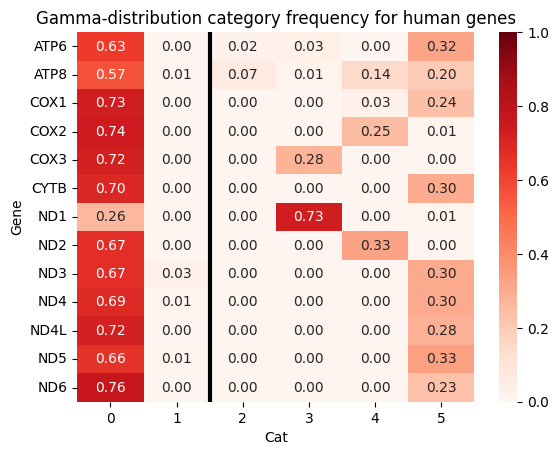

In [11]:
plt.title("Gamma-distribution category frequency for human genes")
sns.heatmap((hrates_cats.T / hrates_cats.sum(axis=1)).T, annot=True, cmap="Reds", fmt=".2f", vmax=1);
plt.vlines([2], 0, 13, 'k', linewidth=3)
plt.savefig("../figures/human_rates.png", dpi=300)
plt.show()

### MUS

In [12]:
path_to_hrates = "../data/mus_rates/"
data = []
for p in glob.glob(path_to_hrates + "*.rate"):
    d = pd.read_csv(p, sep="\t", comment="#")
    d["Gene"] = os.path.basename(p).replace(".rate", "")
    data.append(d)
hrates = pd.concat(data)

In [13]:
hrates_cats = hrates.groupby("Gene").Cat.value_counts().reset_index(name="N").pivot("Gene", "Cat", "N").fillna(0).astype(np.int16)
hrates_cats

Cat,0,1,2,3,4,5
Gene,,,,,,
ATP6,0,0,0,567,82,29
ATP8,141,0,0,53,0,7
COX1,1071,28,11,0,394,38
COX2,464,35,0,0,165,17
COX3,566,0,0,203,0,14
CYTB,760,0,0,333,0,50
ND1,634,0,0,0,257,63
ND2,595,68,24,0,332,16
ND3,0,332,0,0,12,1


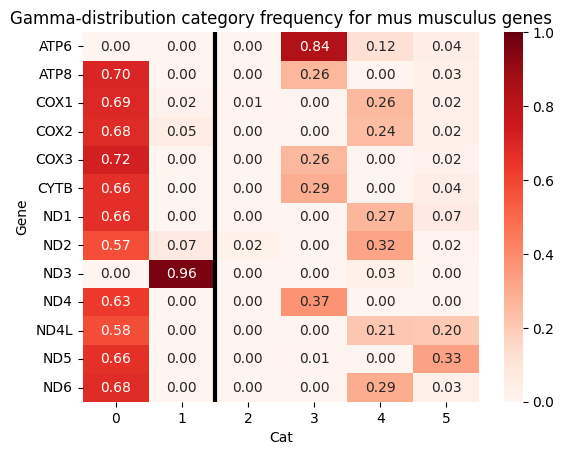

In [14]:
plt.title("Gamma-distribution category frequency for mus musculus genes")
sns.heatmap((hrates_cats.T / hrates_cats.sum(axis=1)).T, annot=True, cmap="Reds", fmt=".2f", vmax=1);
plt.vlines([2], 0, 13, 'k', linewidth=3)
plt.savefig("../figures/mus_rates.png", dpi=300)
plt.show()

## Expected mutations excluding invariant positions

In [2]:
coda = CodonAnnotation(2)

In [16]:
human_cytb = [str(x.seq) for x in SeqIO.parse("../data/exposure/human_cytb/alignment_checked.fasta", format="fasta")]
human_nd1 = [str(x.seq) for x in SeqIO.parse("../data/exposure/human_nd1/alignment_checked.fasta", format="fasta")]
human_cytb_mask = GenesStates.get_mask(GenesStates.read_rates("../data/exposure/human_cytb/CYTB.rate"))[1]
human_nd1_mask = GenesStates.get_mask(GenesStates.read_rates("../data/exposure/human_nd1/ND1.rate"))[1]

mus_cytb = [str(x.seq) for x in SeqIO.parse("../data/exposure/mus_cytb/alignment_checked.fasta", format="fasta")]
mus_nd1 = [str(x.seq) for x in SeqIO.parse("../data/exposure/mus_nd1/alignment_checked.fasta", format="fasta")]
mus_cytb_mask = GenesStates.get_mask(GenesStates.read_rates("../data/exposure/mus_cytb/CYTB.rate"))[1]
mus_nd1_mask = GenesStates.get_mask(GenesStates.read_rates("../data/exposure/mus_nd1/ND1.rate"))[1]

In [17]:
human_cytb_mask.sum(), human_cytb_mask.shape

(340, (1137,))

In [18]:
human_nd1_mask.sum(), human_nd1_mask.shape

(705, (954,))

In [19]:
mus_cytb_mask.sum(), mus_cytb_mask.shape

(383, (1140,))

In [20]:
mus_nd1_mask.sum(), mus_nd1_mask.shape

(290, (885,))

In [7]:
lbl = "syn"

### Human CYTB

In [100]:
exp12, exp192 = defaultdict(int), defaultdict(int)
exp_masked12, exp_masked192 = defaultdict(int), defaultdict(int)
for seq in human_cytb:
    e12, e192  =  coda.collect_exp_mut_freqs(seq, None, [lbl])
    em12, em192 = coda.collect_exp_mut_freqs(seq, human_cytb_mask, [lbl])

    for sbs in e12[lbl]:
        exp12[sbs] += e12[lbl][sbs] / len(human_cytb)
        exp_masked12[sbs] += em12[lbl][sbs] / len(human_cytb)

    for sbs in e192[lbl]:
        exp192[sbs] += e192[lbl][sbs] / len(human_cytb)
        exp_masked192[sbs] += em192[lbl][sbs] / len(human_cytb)


In [94]:
pd.DataFrame([exp12, exp_masked12], index=["exp", "exp_masked"])

,G>A,C>T,C>G,C>A,A>T,A>G,A>C,T>G,T>C,T>A,G>T,G>C
exp,12.844156,208.051948,88.000000,88.000000,88.129870,138.116883,88.129870,16.038961,54.948052,16.038961,6.935065,6.935065
exp_masked,11.805195,123.194805,55.038961,55.038961,40.103896,61.207792,40.103896,15.961039,54.766234,15.961039,6.909091,6.909091


In [119]:
dct = dict()
for sbs in possible_sbs12:
    dct[sbs] = exp_masked12[sbs]
for sbs in possible_sbs192:
    dct[sbs] = exp_masked192.get(sbs, 0.)

exp_muts = pd.Series(dct).reset_index(name="Count").rename(columns={"index": "Mut"})
exp_muts["Label"] = "syn"

exp_muts[["Label", "Mut", "Count"]].to_csv("../data/exposure/human_cytb/exp_muts_invariant.tsv", sep="\t", index=False)

### Human ND1

In [120]:
exp12, exp192 = defaultdict(int), defaultdict(int)
exp_masked12, exp_masked192 = defaultdict(int), defaultdict(int)
for seq in human_nd1:
    e12, e192  =  coda.collect_exp_mut_freqs(seq, None, [lbl])
    em12, em192 = coda.collect_exp_mut_freqs(seq, human_nd1_mask, [lbl])

    for sbs in e12[lbl]:
        exp12[sbs] += e12[lbl][sbs] / len(human_nd1)
        exp_masked12[sbs] += em12[lbl][sbs] / len(human_nd1)

    for sbs in e192[lbl]:
        exp192[sbs] += e192[lbl][sbs] / len(human_nd1)
        exp_masked192[sbs] += em192[lbl][sbs] / len(human_nd1)


In [121]:
pd.DataFrame([exp12, exp_masked12], index=["exp", "exp_masked"])

,A>G,C>A,C>T,C>G,G>A,A>T,A>C,T>C,T>G,T>A,G>C,G>T
exp,116.849462,91.784946,178.784946,91.784946,17.193548,70.064516,70.064516,42.053763,16.096774,16.096774,9.0,9.0
exp_masked,116.849462,91.763441,178.741935,91.763441,17.193548,70.064516,70.064516,37.096774,15.118280,15.118280,9.0,9.0


In [122]:
dct = dict()
for sbs in possible_sbs12:
    dct[sbs] = exp_masked12[sbs]
for sbs in possible_sbs192:
    dct[sbs] = exp_masked192.get(sbs, 0.)

exp_muts = pd.Series(dct).reset_index(name="Count").rename(columns={"index": "Mut"})
exp_muts["Label"] = "syn"

exp_muts[["Label", "Mut", "Count"]].to_csv("../data/exposure/human_nd1/exp_muts_invariant.tsv", sep="\t", index=False)

### Mus CYTB

In [21]:
exp12, exp192 = defaultdict(int), defaultdict(int)
exp_masked12, exp_masked192 = defaultdict(int), defaultdict(int)
for seq in mus_cytb:
    e12, e192  =  coda.collect_exp_mut_freqs(seq, None, [lbl])
    em12, em192 = coda.collect_exp_mut_freqs(seq, mus_cytb_mask, [lbl])

    for sbs in e12[lbl]:
        exp12[sbs] += e12[lbl][sbs] / len(mus_cytb)
        exp_masked12[sbs] += em12[lbl][sbs] / len(mus_cytb)

    for sbs in e192[lbl]:
        exp192[sbs] += e192[lbl][sbs] / len(mus_cytb)
        exp_masked192[sbs] += em192[lbl][sbs] / len(mus_cytb)

dct = dict()
for sbs in possible_sbs12:
    dct[sbs] = exp_masked12[sbs]
for sbs in possible_sbs192:
    dct[sbs] = exp_masked192.get(sbs, 0.)

exp_muts = pd.Series(dct).reset_index(name="Count").rename(columns={"index": "Mut"})
exp_muts["Label"] = "syn"

exp_muts[["Label", "Mut", "Count"]].to_csv("../data/exposure/mus_cytb/exp_muts_invariant.tsv", sep="\t", index=False)

In [35]:
pd.DataFrame([exp12, exp_masked12], index=["exp", "exp_masked"])

,G>A,A>C,A>T,A>G,C>T,T>A,T>C,T>G,C>G,C>A,G>C,G>T
exp,10.602564,105.935897,105.935897,168.602564,151.743590,21.769231,89.128205,21.769231,45.000000,45.000000,5.871795,5.871795
exp_masked,9.410256,74.423077,74.423077,105.987179,142.192308,21.641026,83.038462,21.641026,44.820513,44.820513,5.820513,5.820513


### Mus ND1

In [ ]:
# import re

# from Bio import SeqIO
# import pandas as pd

# rates = pd.read_csv("data/MUS/mus_rates/ND1.rate", sep='\t', comment="#")

# non_letters_positions = set()  # 1-BASED
# for rec in SeqIO.parse("data/exposure/mus_nd1/raw_aln.fna", format="fasta"):
#     seq = str(rec.seq)
#     for i in range(0, len(seq), 3):
#         codon = seq[i: i+3]
#         if not re.match("[A-Za-z]{3}", codon):
#             non_letters_positions.add(i+1)
#             non_letters_positions.add(i+2)
#             non_letters_positions.add(i+3)

# print(sorted(non_letters_positions))

# df = rates[~rates.Site.isin(non_letters_positions)]
# df.to_csv("data/exposure/mus_nd1/ND1.rate", index=False, sep="\t")

In [8]:
exp12, exp192 = defaultdict(int), defaultdict(int)
exp_masked12, exp_masked192 = defaultdict(int), defaultdict(int)
for seq in mus_nd1:
    e12, e192  =  coda.collect_exp_mut_freqs(seq, None, [lbl])
    em12, em192 = coda.collect_exp_mut_freqs(seq, mus_nd1_mask, [lbl])

    for sbs in e12[lbl]:
        exp12[sbs] += e12[lbl][sbs] / len(mus_nd1)
        exp_masked12[sbs] += em12[lbl][sbs] / len(mus_nd1)

    for sbs in e192[lbl]:
        exp192[sbs] += e192[lbl][sbs] / len(mus_nd1)
        exp_masked192[sbs] += em192[lbl][sbs] / len(mus_nd1)

dct = dict()
for sbs in possible_sbs12:
    dct[sbs] = exp_masked12[sbs]
for sbs in possible_sbs192:
    dct[sbs] = exp_masked192.get(sbs, 0.)

exp_muts = pd.Series(dct).reset_index(name="Count").rename(columns={"index": "Mut"})
exp_muts["Label"] = "syn"

exp_muts[["Label", "Mut", "Count"]].to_csv("../data/exposure/mus_nd1/exp_muts_invariant.tsv", sep="\t", index=False)

In [9]:
pd.DataFrame([exp12, exp_masked12], index=["exp", "exp_masked"])

,T>A,T>G,T>C,G>A,C>A,C>G,C>T,A>T,A>C,A>G,G>T,G>C
exp,20.375,20.375,74.875000,9.767857,34.982143,34.982143,101.339286,87.142857,87.142857,153.875000,6.428571,6.428571
exp_masked,19.125,19.125,71.214286,9.642857,33.000000,33.000000,83.392857,57.946429,57.946429,91.267857,6.375000,6.375000
